In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import sys
import gzip
from scipy import stats
import scipy as sp
import community
from sklearn.metrics import mutual_info_score

from network_ei import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

In [9]:
b = 1024
X = np.array([1/b]*b)
HX = sp.stats.entropy(X, base=2)

In [11]:
get_col = lambda col: (line.split('\t')[col-1] for line in open('../../../../../Downloads/iaf1_ivc.dat'))  


In [30]:
m = 1
N = 10
np.random.choice(N,size=(m,),p=[1/N]*N, replace=False)

array([5])

In [10]:
with open('../../../../../Downloads/iaf1_ivc.dat', ) as f:
    [line.split()[7] for line in f] 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc5 in position 0: invalid continuation byte

In [31]:
-np.log2(0.1)

3.3219280948873622

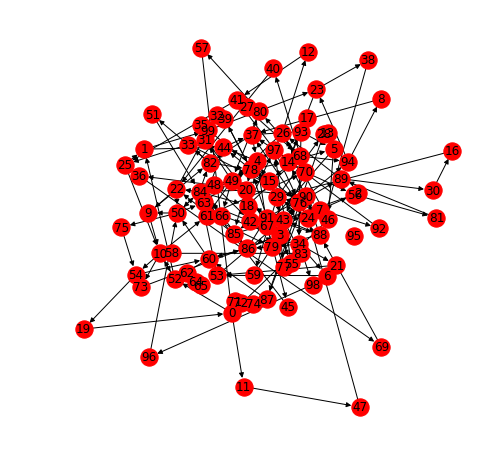

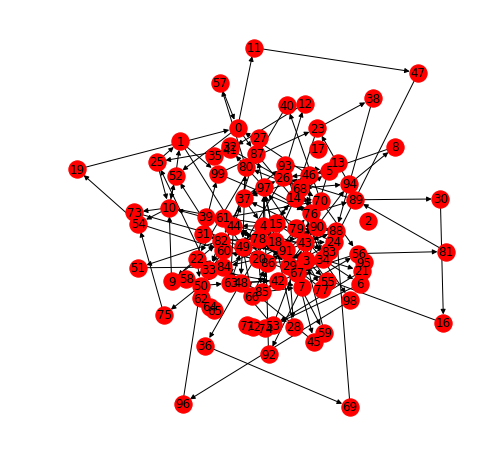

In [102]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)

# t = [1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
t = np.random.choice(np.arange(0,100,1), size=200, replace=True)
m = transition_matrix(t)

xx = nx.from_numpy_array(m, create_using=nx.DiGraph())
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(xx)
nx.draw_networkx_nodes(xx, pos)
nx.draw_networkx_edges(xx, pos)
nx.draw_networkx_labels(xx, pos)
plt.axis('off')
plt.show()

steps = [np.random.choice(list(xx.nodes()))]
n_samps = 10000
for i in range(n_samps):
    current_node = steps[-1]
    next_nodes = list(xx.edges(current_node, data=True))
    next_probs = np.array([next_nodes[i][2]['weight'] for i in range(len(next_nodes))])
    next_hops  = np.array([next_nodes[i][1] for i in range(len(next_nodes))])
    if len(next_hops) == 0:
        next_node = int(np.random.choice(list(xx.nodes()), size=1))
    else: 
        next_node = np.random.choice(next_hops, size=1, p=next_probs)[0]
    steps.append(next_node)
    
m_hat = transition_matrix(steps)
xx = nx.from_numpy_array(m_hat, create_using=nx.DiGraph())
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(xx)
nx.draw_networkx_nodes(xx, pos)
nx.draw_networkx_edges(xx, pos)
nx.draw_networkx_labels(xx, pos)
plt.axis('off')
plt.show()

#     fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(15,5))
#     ax0.imshow(m, cmap='Greys')
#     ax1.imshow(m_hat, cmap='Greys')
#     ax2.imshow(m_hat-m, cmap='Greys', vmax=1)
#     plt.show()


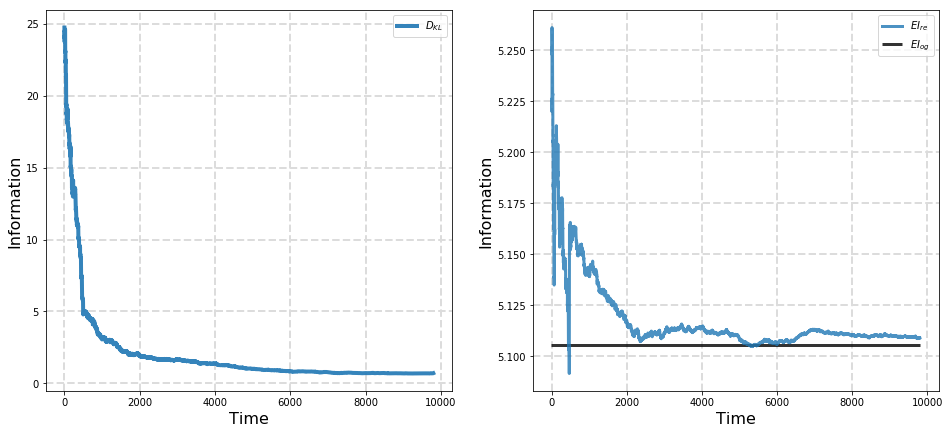

In [111]:
steps = [np.random.choice(list(xx.nodes()))]
n_samps = 10000
for i in range(n_samps):
    current_node = steps[-1]
    next_nodes = list(xx.edges(current_node, data=True))
    next_probs = np.array([next_nodes[i][2]['weight'] for i in range(len(next_nodes))])
    next_hops  = np.array([next_nodes[i][1] for i in range(len(next_nodes))])
    if len(next_hops) == 0:
        next_node = int(np.random.choice(list(xx.nodes()), size=1))
    else: 
        next_node = np.random.choice(next_hops, size=1, p=next_probs)[0]
    steps.append(next_node)
    
klds=[]
eis =[]
for samp in np.arange(200,n_samps):
    m_hat = transition_matrix(steps[:samp])
    klds.append(sum([sp.stats.entropy(m_hat[i], m[i]) for i in range(m_hat.shape[0]) if sum(m_hat[i])!=0.0]))
    eis.append(get_ei(m_hat, p0=0))

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,7))
ax0.plot(klds, linewidth=4.0, linestyle='-', alpha=0.9, label=r"$D_{KL}$")
ax0.set_ylabel("Information", size=16)
ax0.set_xlabel("Time", size=16)
ax0.grid(color='gainsboro', linewidth=2.0, linestyle='--')
ax0.legend()
ax1.plot(eis, linewidth=3.0, linestyle='-', alpha=0.8, label=r"$EI_{re}$")
ax1.hlines(get_ei(m,p0=0), -10, len(klds)+10, linewidth=3.0, linestyle='-', alpha=0.8, label=r"$EI_{og}$")
ax1.set_ylabel("Information", size=16)
ax1.set_xlabel("Time", size=16)
ax1.grid(color='gainsboro', linewidth=2.0, linestyle='--')
ax1.legend()
plt.show()